<a href="https://colab.research.google.com/github/falahamro/Deep-Learning/blob/main/Toxicity_Prediction_Domestic_Violent_Extremists_(DMV)_Narrative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TOXICITY ANALYSIS AND COMMENTS CLASSIFICATION**

Exploration, feature engineering and classification in online comment toxicity detection and classification






In [1]:
# import required libraries
import pandas as pd
import numpy as np
import re
import string
import itertools as it
import pickle
import os
from  pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords                  # module for stop words that come with NLTK
from nltk.stem.wordnet import WordNetLemmatizer    # module for lemmatization
from nltk import word_tokenize, pos_tag            # tokenization and Part of Speech tagging

nltk.download('stopwords') #stopwords used to preprocess the corpus

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import missingno
from scipy import interp
#import scikitplot as skplt
from itertools import cycle
import matplotlib.ticker as plticker

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix

import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
stopwords_english = stopwords.words('english') # list of English stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading our datasets

In [2]:
from google.colab import drive
drive.mount('/content/dtive')

Drive already mounted at /content/dtive; to attempt to forcibly remount, call drive.mount("/content/dtive", force_remount=True).


In [3]:
train_df = pd.read_csv("/content/dtive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/toxic_train.csv")
#train_df['id'] = train_df[['id']].sum(axis=1).map(hash)

In [4]:
test_df = pd.read_csv("/content/dtive/MyDrive/Colab Notebooks/Clustering_Kmeans/Holistic Identity Mapping.csv")

In [5]:
test_df

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count
0,9.037520e+17,1771,3576,8,45328,@ofpeopl @agargmd Many people know the stopthe...,2021-01-28 23:59:15+00:00,0,0,0,0
1,2.518376e+09,4,37,0,421,I'd say I'm shocked by just how naive/ignorant...,2021-01-28 23:55:00+00:00,0,0,0,0
2,1.724066e+07,394,954,0,23278,And then there is Dave LaRock -- to be fair --...,2021-01-28 23:54:51+00:00,2,1,3,0
3,1.900454e+07,289,471,2,34442,@govkristinoem Yes. Joe #NotMyPresident and he...,2021-01-28 23:52:46+00:00,0,0,1,0
4,1.250970e+18,1727,2557,3,18984,@SenatorRomney We could've worked to #StopTheS...,2021-01-28 23:52:41+00:00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
66441,2.996814e+09,7,29,1,113,@SenTedCruz You are our last hope... Do what y...,2020-12-20 00:06:56+00:00,0,0,0,0
66442,1.712432e+08,106,440,1,6148,"@jaketapper No judge has laughed, and she will...",2020-12-20 00:04:58+00:00,0,0,0,0
66443,7.659790e+17,6129,1000,10,24696,True.\n\nBUT!!...\n\nEvery day YOU don’t fight...,2020-12-20 00:02:55+00:00,0,0,0,0
66444,2.945379e+09,4139,4997,0,97757,#DoNotRatifyFraud!⚖️#StopTheSteal!\n*Demand Yo...,2020-12-20 00:02:07+00:00,0,0,0,0


In [6]:
test_df['CandidateA'] = test_df['author_id'] 
test_df['CandidateA'] = test_df.loc[:, 'author_id']
test_df

,author_id,followers_count,following_count,listed_count,tweet_count,text,created_at,retweet_count,reply_count,like_count,quote_count,CandidateA
0,9.037520e+17,1771,3576,8,45328,@ofpeopl @agargmd Many people know the stopthe...,2021-01-28 23:59:15+00:00,0,0,0,0,9.037520e+17
1,2.518376e+09,4,37,0,421,I'd say I'm shocked by just how naive/ignorant...,2021-01-28 23:55:00+00:00,0,0,0,0,2.518376e+09
2,1.724066e+07,394,954,0,23278,And then there is Dave LaRock -- to be fair --...,2021-01-28 23:54:51+00:00,2,1,3,0,1.724066e+07
3,1.900454e+07,289,471,2,34442,@govkristinoem Yes. Joe #NotMyPresident and he...,2021-01-28 23:52:46+00:00,0,0,1,0,1.900454e+07
4,1.250970e+18,1727,2557,3,18984,@SenatorRomney We could've worked to #StopTheS...,2021-01-28 23:52:41+00:00,0,0,1,0,1.250970e+18
...,...,...,...,...,...,...,...,...,...,...,...,...
66441,2.996814e+09,7,29,1,113,@SenTedCruz You are our last hope... Do what y...,2020-12-20 00:06:56+00:00,0,0,0,0,2.996814e+09
66442,1.712432e+08,106,440,1,6148,"@jaketapper No judge has laughed, and she will...",2020-12-20 00:04:58+00:00,0,0,0,0,1.712432e+08
66443,7.659790e+17,6129,1000,10,24696,True.\n\nBUT!!...\n\nEvery day YOU don’t fight...,2020-12-20 00:02:55+00:00,0,0,0,0,7.659790e+17
66444,2.945379e+09,4139,4997,0,97757,#DoNotRatifyFraud!⚖️#StopTheSteal!\n*Demand Yo...,2020-12-20 00:02:07+00:00,0,0,0,0,2.945379e+09


In [7]:
test_df.rename(columns = {'author_id':'id'}, inplace=True)

test_df.rename(columns = {'text':'comment_text'}, inplace=True)

#test_df = test_df[["id", "comment_text"]]

In [8]:
test_label_data = pd.read_csv("/content/dtive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/test_labels.csv")
test_label_data['id'] = test_label_data[['id']].sum(axis=1).map(hash)

In [9]:
print("We have {} Rows and {} in our dataframe".format(train_df.shape[0], train_df.shape[1]))
train_df.head(10)

We have 159571 Rows and 8 in our dataframe


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Here is a look at the training dataset and can see that the dataframe has a total of 159571 rows and 8 columns. The id column has no weight except in labeling the remaining columns in binary labels. 

Column Description: 



*   id: a unique id aligned with each comment text. 
*   comment_text
*   toxic
*   severe_toxic
*   obscene
*   threat
*   insult
*   identity_hate






In [10]:
test_df

,id,followers_count,following_count,listed_count,tweet_count,comment_text,created_at,retweet_count,reply_count,like_count,quote_count,CandidateA
0,9.037520e+17,1771,3576,8,45328,@ofpeopl @agargmd Many people know the stopthe...,2021-01-28 23:59:15+00:00,0,0,0,0,9.037520e+17
1,2.518376e+09,4,37,0,421,I'd say I'm shocked by just how naive/ignorant...,2021-01-28 23:55:00+00:00,0,0,0,0,2.518376e+09
2,1.724066e+07,394,954,0,23278,And then there is Dave LaRock -- to be fair --...,2021-01-28 23:54:51+00:00,2,1,3,0,1.724066e+07
3,1.900454e+07,289,471,2,34442,@govkristinoem Yes. Joe #NotMyPresident and he...,2021-01-28 23:52:46+00:00,0,0,1,0,1.900454e+07
4,1.250970e+18,1727,2557,3,18984,@SenatorRomney We could've worked to #StopTheS...,2021-01-28 23:52:41+00:00,0,0,1,0,1.250970e+18
...,...,...,...,...,...,...,...,...,...,...,...,...
66441,2.996814e+09,7,29,1,113,@SenTedCruz You are our last hope... Do what y...,2020-12-20 00:06:56+00:00,0,0,0,0,2.996814e+09
66442,1.712432e+08,106,440,1,6148,"@jaketapper No judge has laughed, and she will...",2020-12-20 00:04:58+00:00,0,0,0,0,1.712432e+08
66443,7.659790e+17,6129,1000,10,24696,True.\n\nBUT!!...\n\nEvery day YOU don’t fight...,2020-12-20 00:02:55+00:00,0,0,0,0,7.659790e+17
66444,2.945379e+09,4139,4997,0,97757,#DoNotRatifyFraud!⚖️#StopTheSteal!\n*Demand Yo...,2020-12-20 00:02:07+00:00,0,0,0,0,2.945379e+09


Our test data is significantly smaller than the training dataset. At this point, we're testing our model- we will be adding more contextualized data. 

In [11]:
train_df.isna().sum() # checking for missing values

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We can confirm that there are no missing values in any of the columns present in the training dataset

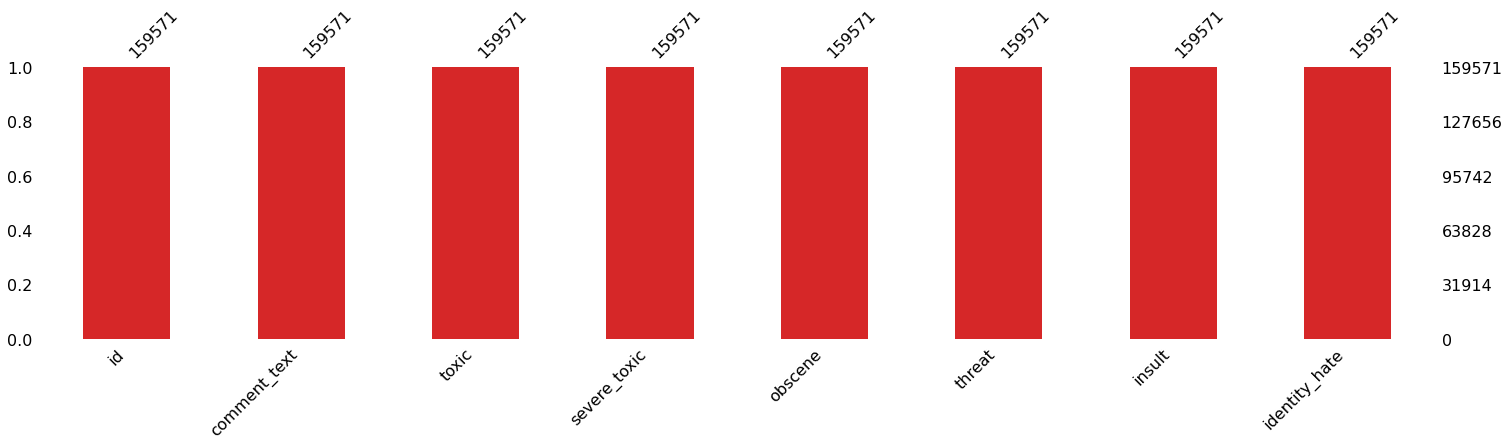

In [12]:
missingno.bar(train_df, figsize = (25,5), color="tab:red")

We get another confirmation with visuals that none of the columns in our dataset has any null values. 

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Out of the 8 columns we have, 2 have object datatype while the remaining 6 columns are integer datatype. 

**Class imbalance in train set**

In [14]:
# checking ratio of data which contains toxic comments and normal or inoffensive comments.

output_labels = train_df.columns[2:]

# checking non-zero rows i.e: finding toxic comments 
toxic_comments = len(train_df[train_df[output_labels].any(axis=1)])

# counting rows containing zero i.e normal comments 

normal_comments = len(train_df)-toxic_comments

print(f"Total Toxic Comments: {toxic_comments} ({round(toxic_comments*100/len(train_df),2)}%)")
print(f"Total Normal Comments: {normal_comments} ({round(normal_comments*100/len(train_df),2)}%)")

Total Toxic Comments: 16225 (10.17%)
Total Normal Comments: 143346 (89.83%)


The ratio above shows that our dataframe consists of 10.17% of toxic comments and 89.83% of normal comments. Hence, it is clear that the dataset is imbalanced and needs to be treated accordingly during train test split of model training. 



**Number of occurrences of the label types**

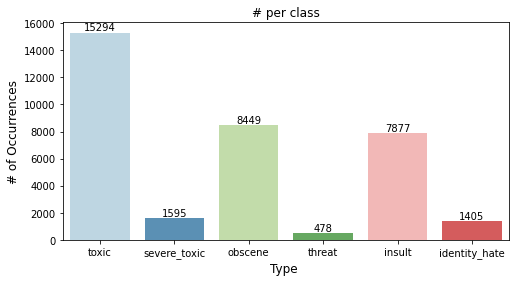

In [15]:
x = train_df.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette = "Paired")
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

# adding the text labels 
rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

View a sample of the testing data

In [16]:
for i in range (10):
  print(test_df['comment_text'][i])
  print('----------------------')

@ofpeopl @agargmd Many people know the stopthesteal protests were infiltrated by antifa people.
----------------------
I'd say I'm shocked by just how naive/ignorant many of those complaining about RobinHood, Etrade, TD, etc stopping the opening of new positions in GME (and others) but then again QAnon and StopTheSteal.
----------------------
And then there is Dave LaRock -- to be fair -- he should also be Censured -- in fact he participated in a number #StopTheSteal orgies of dysfunction, racism, and obeisance @EFillerCorn , @PriceForDel95 @marcussimon @ https://t.co/Nhyc7fiB2s
----------------------
@govkristinoem Yes. Joe #NotMyPresident and he is #ilegitamate  #stopthesteal
----------------------
@SenatorRomney We could've worked to #StopTheSteal, and retained our President, who would've helped Americans instead of hurting us, but Uniparty RINOs like Romney wanted to install #BeijingBiden instead.
----------------------
Nancy Pelosi gets away with saying “the enemy within” and the 

In [17]:
# checking the length of comments and storing it into another column 'original_length'
# we copy the train_df into another object df

df = train_df.copy()
df['original_length'] = df.comment_text.str.len()

# check the first five and last five rows here

df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [18]:
#Let's check in the test.csv

test_label_data.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,3759750117966506392,-1,-1,-1,-1,-1,-1
1,5239315839385927495,-1,-1,-1,-1,-1,-1
2,-7369949823561314444,-1,-1,-1,-1,-1,-1
3,3336448451592395333,-1,-1,-1,-1,-1,-1
4,-8897923527241246549,-1,-1,-1,-1,-1,-1
5,-4117311682771065629,0,0,0,0,0,0
6,4066811747514514310,-1,-1,-1,-1,-1,-1
7,5086017279877890918,0,0,0,0,0,0
8,8414266984837879581,-1,-1,-1,-1,-1,-1
9,-5720691218751171148,-1,-1,-1,-1,-1,-1


The test label dataset contains IDs and classification. -1 means IDs were not used for scoring. 

In [19]:
# The test label dataset will be ised to define the accuracy of the models. 

test_label_data = test_label_data.loc[test_label_data['toxic']!=-1]

In [20]:
# Let's calculate the % of toxic comments
test_label_data.iloc[:,1:-1].sum(axis=0) / test_label_data.shape[0]

toxic           0.095189
severe_toxic    0.005736
obscene         0.057692
threat          0.003298
insult          0.053565
dtype: float64

In [21]:
#test_df['id'] = test_df[['id']].sum(axis=1).map(hash)

#test_df

In [22]:
#let's group comments and classifications with IDs

#test = test_label_data.merge(test_df, on='id', how="inner")
#test.head(5)

**Data Cleaning**

In [23]:
# as the feature 'id' has no relevance w.r.t. model training I am dropping this column
df.drop(columns=['id'],inplace=True)
# converting comment text to lowercase format
df['comment_text'] = df.comment_text.str.lower()
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,264
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,112
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,67


Since there was no use of the "id" column I have dropped it and converted all the text data in our comment text column into lowercase format for easier interpretation



**Removing and Replacing unwanted characters in the comment_text column**


In [24]:
# Replacing '\n' with ' '
df.comment_text = df.comment_text.str.replace('\n',' ')

# Keeping only text with letters a to z, 0 to 9 and words like can't, don't, couldn't etc
df.comment_text = df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Removing Stop Words and Punctuations

# Getting the list of stop words of english language as set
stop_words = set(stopwords.words('english'))

# Updating the stop_words set by adding letters from a to z
for ch in range(ord('a'),ord('z')+1):
    stop_words.update(chr(ch))
    
# Updating stop_words further by adding some custom words
custom_words = ("d'aww","mr","hmm","umm","also","maybe","that's","he's","she's","i'll","he'll","she'll","us",
                "ok","there's","hey","heh","hi","oh","bbq","i'm","i've","nt","can't","could","ur","re","ve",
                "rofl","lol","stfu","lmk","ily","yolo","smh","lmfao","nvm","ikr","ofc","omg","ilu")
stop_words.update(custom_words)

# Checking the new list of stop words
print("New list of custom stop words are as follows:\n\n")
print(stop_words)

New list of custom stop words are as follows:


{'with', 'c', 'maybe', 'the', 'umm', 'into', 'you', "needn't", 'hers', 're', 'have', 'of', 'but', 'from', 'now', 'bbq', 'no', 'who', 'its', 'between', 'weren', "hadn't", "you've", 'him', 'as', 'where', 'am', 'me', 'each', 'lmfao', 'does', "aren't", 'o', "weren't", 'both', 'on', 'u', 'z', 'mightn', 'ourselves', 'l', 'couldn', 'ok', 'not', "mustn't", 'nvm', "she'll", 'then', 'ily', 'lmk', 'heh', 'by', 'could', 'being', 'is', 'other', 'more', 'ain', 'and', 'those', 'yours', 'her', 'mr', 'again', 'which', 'isn', 'oh', 'while', 'such', "there's", 'yolo', 'off', 'been', "you're", 'shan', 'his', "don't", 'under', 'lol', 'why', "isn't", 'themselves', 'an', 'haven', 'them', "shan't", 'we', 'was', 'during', 'your', 'j', "hasn't", 'she', "that'll", 'our', 'very', "shouldn't", 't', 'hmm', 'below', 'that', 'don', "that's", 'doing', "he's", 'do', 'against', 'own', 'because', 'rofl', 'for', 'or', 'had', 'same', 'ilu', 'he', 'are', 'were', 'to', 'wasn', 

In [25]:
# Removing stop words
df.comment_text = df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Removing punctuations
df.comment_text = df.comment_text.str.replace("[^\w\d\s]","")

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
124178,preceding unsigned comment added,0,0,0,0,0,0,59
48211,people hoping begging wishing previlages respe...,0,0,0,0,0,0,4912
85852,marilyn manson herd marilyn manson shock rock ...,0,0,0,0,0,0,194
116335,nobody else agree picture changed opening pict...,1,0,0,0,0,0,217
86506,ones complement histmerge done histmerge thank...,0,0,0,0,0,0,106
132050,still unblocked sake asking,0,0,0,0,0,0,41
37855,another account wikipedia use addition one ngo,0,0,0,0,0,0,99
139881,bash barename basename sed s barename dira di...,0,0,0,0,0,0,122
93803,hayley hutchinson prod template added article ...,0,0,0,0,0,0,1055
128184,love cyde love,0,0,0,0,0,0,32


In [26]:
# Stemming words
snb_stem = SnowballStemmer('english')
df.comment_text = df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
137171,atroci liar bob rayner wrote valu form articl ...,1,0,0,0,0,0,1143
4443,critic stub articl,0,0,0,0,0,0,25
83379,remov erron refer movement associ communism co...,0,0,0,0,0,0,742
96880,regard edit,0,0,0,0,0,0,21
137766,specif section dedic harm effect masturb benef...,0,0,0,0,0,0,397
16783,two reliabl sourc,0,0,0,0,0,0,40
139069,ew einbau waff odd weapon semi automat belt fe...,0,0,0,0,0,0,323
150160,august tag place dinesh robinson request speed...,0,0,0,0,0,0,2583
153565,puzzl world wikipedia talk arbitr committe not...,0,0,0,0,0,0,721
97869,august utc done object suggest wait sever day,0,0,0,0,0,0,107


In [27]:
# Checking the length of comment_text after cleaning and storing it in cleaned_length variable
df["cleaned_length"] = df.comment_text.str.len()

# Taking a loot at first 10 rows of data
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length,cleaned_length
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,264,135
1,match background colour seem stuck thank talk ...,0,0,0,0,0,0,112,57
2,man realli tri edit war guy constant remov rel...,0,0,0,0,0,0,233,112
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,622,310
4,sir hero chanc rememb page,0,0,0,0,0,0,67,26
5,congratul well use tool well talk,0,0,0,0,0,0,65,33
6,cocksuck piss around work,1,1,1,0,1,0,44,25
7,vandal matt shirvington articl revert pleas ban,0,0,0,0,0,0,115,47
8,sorri word nonsens offens anyway intend write ...,0,0,0,0,0,0,472,235
9,align subject contrari dulithgow,0,0,0,0,0,0,70,32


In [28]:
# Now checking the percentage of length cleaned
print(f"Total Original Length        : {df.original_length.sum()}")
print(f"Total Cleaned Length         : {df.cleaned_length.sum()}")
print(f"Percentage of Length Cleaned : {(df.original_length.sum()-df.cleaned_length.sum())*100/df.original_length.sum()}%")


Total Original Length        : 62882658
Total Cleaned Length         : 34297857
Percentage of Length Cleaned : 45.457367594098834%


**Visualization**

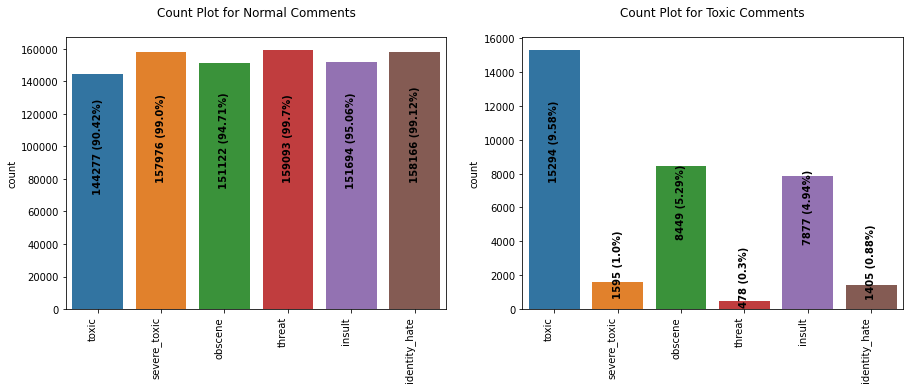

In [29]:
# comparing normal comments and bad comments using count plot

fig, ax = plt.subplots(1,2,figsize=(15,5))

for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Toxic Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()

Observation:

Dataset consists of higher number of Normal Comments than tpxic Comments. Therefore, it is clear that dataset is imbalanced and needs to be handle accordingly.
Most of the toxic comments are of type toxic while least number of type threat is present in dataset.

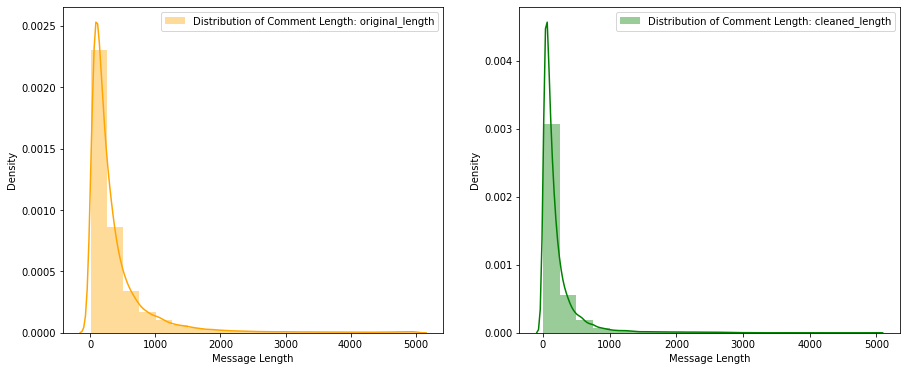

In [30]:
# Comparing the comment text length distribution before cleaning and after cleaning

fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

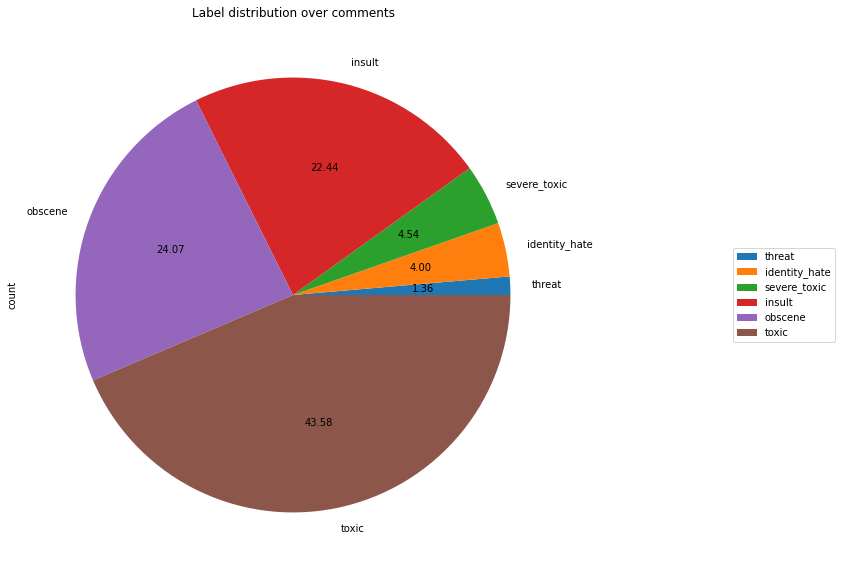

In [31]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_distribution = train_df[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

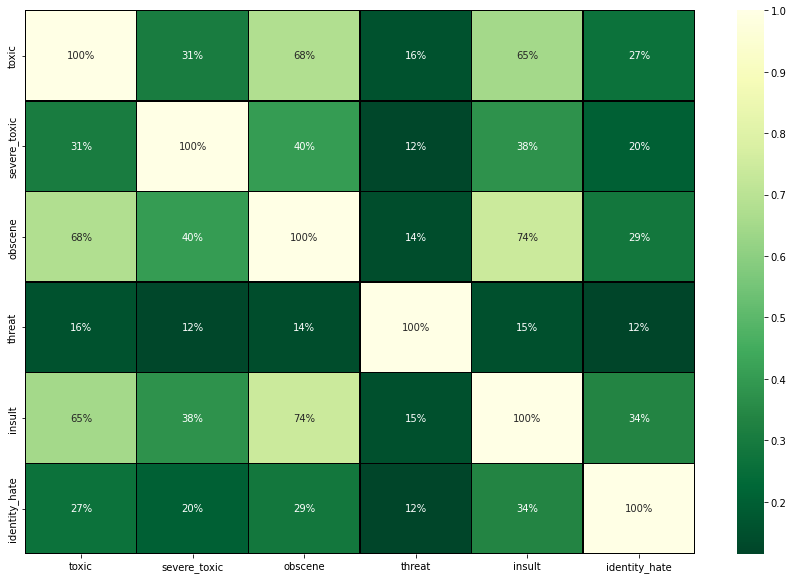

In [32]:
# Plotting heatmap for visualizing the correlation

plt.figure(figsize=(15, 10))
corr = train_df.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='YlGn_r', annot=True)
plt.show()

**WordCloud: Getting sense of cloud words in each of the output labels**


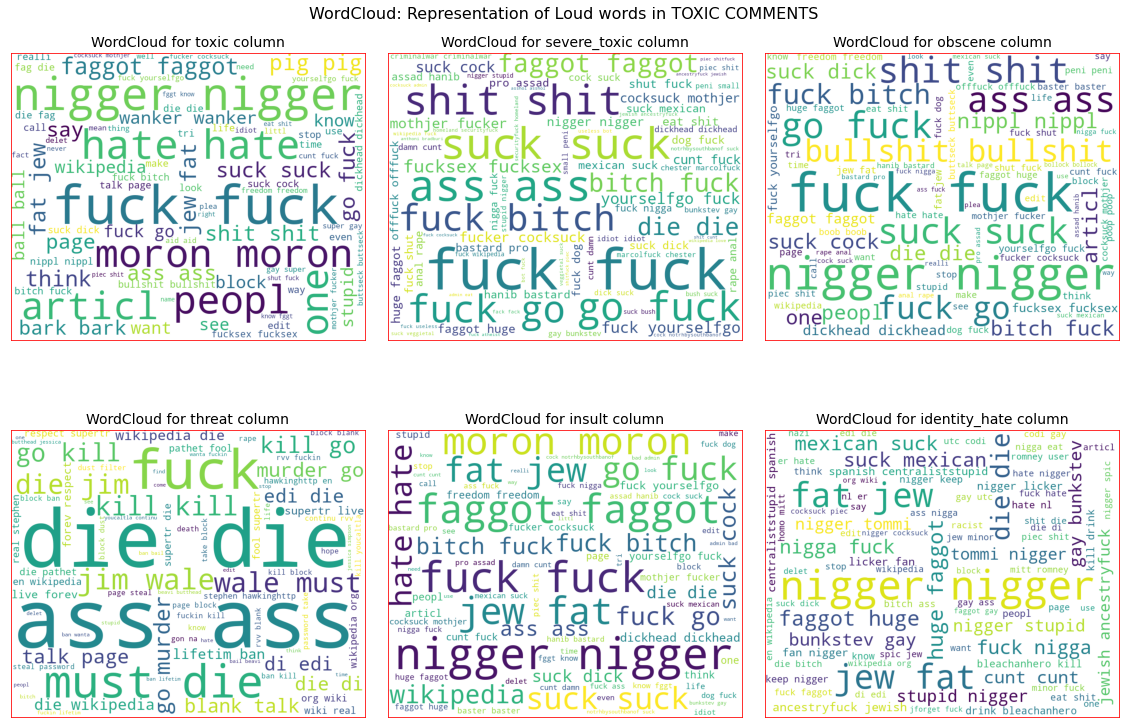

In [33]:
cols = 3
rows = len(output_labels)//cols
if len(output_labels) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(16,rows*cols*1.8))
fig.subplots_adjust(top=0.8, hspace=0.3)

p=1
for i in output_labels:
    word_cloud = WordCloud(height=650, width=800,
                           background_color="white",max_words=80).generate(' '.join(df.comment_text[df[i]==1]))
    ax = fig.add_subplot(rows,cols,p)
    ax.imshow(word_cloud)
    ax.set_title(f"WordCloud for {i} column",fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('r')
       
    ax.set_xticks([])
    ax.set_yticks([])
    p += 1

fig.suptitle("WordCloud: Representation of Loud words in TOXIC COMMENTS",fontsize=16)
fig.tight_layout(pad=2)
plt.show()

Observation:

1. From wordcloud of toxic comments, it is clear that it mostly consists of words like fuck, nigger, moron, hate, suck ect.

2. From wordcloud of severe_toxic comments, it is clear that it mostly consists of words like ass, fuck, bitch, shit, die, suck, faggot ect.

3. From wordcloud of obscene comments, it is clear that it mostly consists of words like nigger, ass, fuck, suck, bullshit, bitch etc.

4. From wordcloud of threat comments, it is clear that it mostly consists of words like die, must die, kill, murder etc.

5. From wordcloud of insult comments, it is clear that it mostly consists of words like moron, nigger, fat, jew, bitch etc.

6. From wordcloud of identity_hate comments, it is clear that it mostly consists of words like nigga, stupid, nigger, die, gay cunt etc.

We could potentially expand our stopwords to include some of these words. 




In [34]:
#stopwords.extend(['fuck', 'nigger', 'moron', 'hate', 'suck', 'ass', 'fuck', 'bitch', 'shit', 'die', 'suck', 'faggot'])

**Data Preparation for Model Training and Testing**

1. Convert text to Vectors

In [35]:
# Converting text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=4000)
features = tfidf.fit_transform(df.comment_text).toarray()

# Checking the shape of features
features.shape

(159571, 4000)

2. Seperating Input and Output Variables

In [36]:
# input variables
X = features

# output variables
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)

Input Variable Shape: (159571, 4000)
Output Variable Shape: (159571, 6)


**Classification Machine Learning Model Building**

3. Training and Testing Model on our train dataset

In [37]:
# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [41]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

In [42]:
# Preparing the list of models for classification purpose
models = {"GaussianNB": {"name": GaussianNB()},
          "MultinomialNB": {"name": MultinomialNB()},
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
          "K Nearest Neighbors Classifier": {"name": KNeighborsClassifier()},
          "Decision Tree Classifier": {"name": DecisionTreeClassifier()},
          "Bagging Classifier": {"name": BaggingClassifier(base_estimator=LinearSVC())},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])

Building Models:   0%|          | 0/9 [00:00<?, ?it/s]


Current Model in Progress: GaussianNB 
Training:  BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.21543233320673502
	Accuracy Score: 0.4730725408279529
              precision    recall  f1-score   support

           0       0.16      0.79      0.26      1281
           1       0.08      0.46      0.13       150
           2       0.11      0.71      0.19       724
           3       0.02      0.25      0.03        44
           4       0.10      0.65      0.17       650
           5       0.04      0.46      0.07       109

   micro avg       0.11      0.70      0.20      2958
   macro avg       0.08      0.55      0.14      2958
weighted avg       0.12      0.70      0.21      2958
 samples avg       0.05      0.07      0.05      2958
Completed in [16.643659909001144 sec.]

Current Model in Progress: MultinomialNB 
Training:  BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.02409

In [43]:
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
from keras.models import model_from_json

In [44]:
import torch
import torchvision

In [45]:
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.2


In [47]:
# selecting the best model
best_model = trained_models['MultinomialNB']['trained']

# saving the best classification model
joblib.dump(best_model,open('MultinomialNB_Toxic_comments_classifier.pkl','wb'))

In [48]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Support Vector Classifier_Toxic_comments_classifier.pkl','wb'))

In [49]:
# selecting the best model
best_model = trained_models['GaussianNB']['trained']

# saving the best classification model
joblib.dump(best_model,open('GaussianNB_Toxic_comments_classifier.pkl','wb'))

In [50]:
# selecting the best model
best_model = trained_models['Logistic Regression']['trained']

# saving the best classification model
joblib.dump(best_model,open('Logistic Regression_Toxic_comments_classifier.pkl','wb'))

In [51]:
# selecting the best model
best_model = trained_models['Random Forest Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Random Forest Classifier_Toxic_comments_classifier.pkl','wb'))

In [52]:
# selecting the best model
best_model = trained_models['Ada Boost Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Ada Boost Classifier_Toxic_comments_classifier.pkl','wb'))

In [53]:
# selecting the best model
best_model = trained_models['K Nearest Neighbors Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('K Nearest Neighbors Classifier_Toxic_comments_classifier.pkl','wb'))

In [54]:
# selecting the best model
best_model = trained_models['Decision Tree Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Decision Tree Classifier_Toxic_comments_classifier.pkl','wb'))

In [55]:
# selecting the best model
best_model = trained_models['Bagging Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Bagging Classifier_Toxic_comments_classifier.pkl','wb'))

In [56]:
import pickle

In [57]:

# save the model to disk
filename = 'models.sav'
pickle.dump(models, open(filename, 'wb')) 

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

**Hyperparameter Tuning**

In [58]:
# Choosing Linear Support Vector Classifier model

fmod_param = {'estimator__penalty' : ['l1', 'l2'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111]
             }
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_

{'estimator__loss': 'hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': 42}

After comparing all the classification models I have selected Linear Support Vector Classifier as my best model and have listed down it's parameters above referring the sklearn webpage. I am using the Grid Search CV method for hyper parameter tuning my best model. I have trained the Grid Search CV with the list of parameters I feel it should check for best possible outcomes. So the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model that I can use on my final model.

In [59]:
Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', multi_class='ovr', penalty='l2', random_state=42))
Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.51069518716578
Hamming loss for the Best Model is: 1.9593917112299464


I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the accuracy score for it.



**AUC ROC Curve for Final Model**

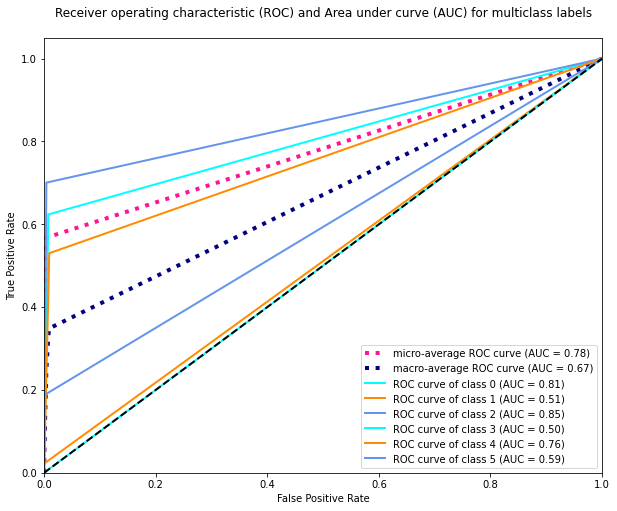

In [60]:
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], fmod_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), fmod_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) and Area under curve (AUC) for multiclass labels\n")
plt.legend(loc="lower right")
plt.show()

I have generated the ROC Curve for my final model and it shows separate curve for every class present in our multi label target variable along with it's AUC values.

**Confusion Matrix for Final Model**

In [61]:
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))

Confusion matrix:

 [[[10710    83]
  [  442   733]]

 [[11832     1]
  [  132     3]]

 [[11263    47]
  [  197   461]]

 [[11930     0]
  [   38     0]]

 [[11266   106]
  [  280   316]]

 [[11869     3]
  [   78    18]]]


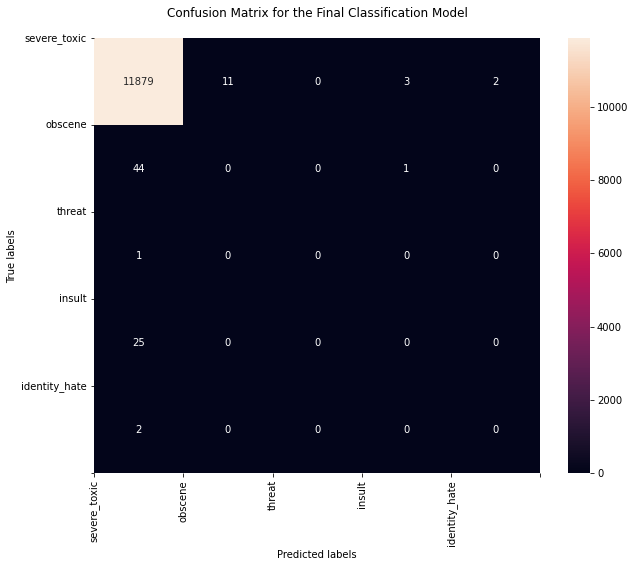

In [62]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plticker.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my final model missed to provide the correct prediction (depicting in the black boxes).

**Model Saving or Serialization**

In [63]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Toxic_comments_classifier.pkl','wb'))

**Preprocessing Pipeline for test dataframe**

The following preprocessing pipeline is required to perform model prediction:

1. Use the test dataset

2. Remove null values if any

3. Drop column id

4. Convert comment text to lower case and replace '\n' with single space

5. Keep only text data ie. a-z' and remove other data from comment text

6. Remove stop words and punctuations

7. Apply Stemming using SnowballStemmer

8. Convert text to vectors using TfidfVectorizer

9. Load saved or serialized best model

10. Predict values and create a new CSV file

In [64]:
# Remove null values
if test_df.isnull().sum()[1] != 0:
    test_df.dropna(inplace=True)
    
# Drop coulmn id
test_df.drop(columns=['id'],inplace=True)

# Convert comment text to lower case and replace '\n' with single space
test_df["comment_text"] = test_df.comment_text.str.lower()
test_df["comment_text"] = test_df.comment_text.str.replace('\n',' ')

# Keep only text data i.e., a-z' and remove other data from comment text.
test_df.comment_text = test_df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Remove stopwords
test_df.comment_text = test_df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Remove punctuations
test_df.comment_text = test_df.comment_text.str.replace("[^\w\d\s]","")

# Apply Stemming using SnowballStemmer
test_df.comment_text = test_df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

print(test_df.info(memory_usage="deep"))

# Convert text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
test_features = tfidf.fit_transform(test_df.comment_text).toarray()

# Load saved or serialized model and predict
model_loaded = joblib.load('Toxic_comments_classifier.pkl')

# Make predictions and view the results
predict_test = model_loaded.predict(test_features)

# Saving predicted values into a CSV file
pd.DataFrame(predict_test.toarray()).to_csv('Predicted_test_output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66446 entries, 0 to 66445
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   followers_count  66446 non-null  int64  
 1   following_count  66446 non-null  int64  
 2   listed_count     66446 non-null  int64  
 3   tweet_count      66446 non-null  int64  
 4   comment_text     66446 non-null  object 
 5   created_at       66446 non-null  object 
 6   retweet_count    66446 non-null  int64  
 7   reply_count      66446 non-null  int64  
 8   like_count       66446 non-null  int64  
 9   quote_count      66446 non-null  int64  
 10  CandidateA       66446 non-null  float64
dtypes: float64(1), int64(8), object(2)
memory usage: 21.2 MB
None


In [89]:
df1 = pd.read_csv('Predicted_test_output.csv')
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1.rename({'0':'toxic', '1':'severe_toxic', '2':'obscene', '3':'threat', '4':'insult', '5':'identity_hate'}, 
           axis='columns', inplace=True)
df2=test_df.copy()
df = pd.concat([df2, df1], axis=1)
df

,followers_count,following_count,listed_count,tweet_count,comment_text,created_at,retweet_count,reply_count,like_count,quote_count,CandidateA,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1771,3576,8,45328,ofpeopl agargmd mani peopl know stopthest prot...,2021-01-28 23:59:15+00:00,0,0,0,0,9.037520e+17,0,0,0,0,0,0
1,4,37,0,421,id say shock naiv ignor mani complain robinhoo...,2021-01-28 23:55:00+00:00,0,0,0,0,2.518376e+09,0,0,0,0,0,0
2,394,954,0,23278,dave larock fair censur fact particip number s...,2021-01-28 23:54:51+00:00,2,1,3,0,1.724066e+07,0,0,0,0,0,0
3,289,471,2,34442,govkristinoem yes joe notmypresid ilegitam sto...,2021-01-28 23:52:46+00:00,0,0,1,0,1.900454e+07,1,0,0,0,0,1
4,1727,2557,3,18984,senatorromney couldv work stopthest retain pre...,2021-01-28 23:52:41+00:00,0,0,1,0,1.250970e+18,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66441,7,29,1,113,sentedcruz last hope know must pleas back rep ...,2020-12-20 00:06:56+00:00,0,0,0,0,2.996814e+09,1,0,0,0,0,0
66442,106,440,1,6148,jaketapp judg laugh last laugh ps fu tapper st...,2020-12-20 00:04:58+00:00,0,0,0,0,1.712432e+08,0,0,0,0,0,0
66443,6129,1000,10,24696,true everi day fight novemb elect transpar amp...,2020-12-20 00:02:55+00:00,0,0,0,0,7.659790e+17,0,0,0,0,0,0
66444,4139,4997,0,97757,donotratifyfraud stopthest demand state repres...,2020-12-20 00:02:07+00:00,0,0,0,0,2.945379e+09,0,0,0,0,0,0


In [90]:
# let's  view examples from the predicted rows 

df['comment_text'][3]

'govkristinoem yes joe notmypresid ilegitam stopthest'

In [91]:
df['comment_text'][66441]

'sentedcruz last hope know must pleas back rep mo brook januari th hero america need stopthest'

In [92]:
df['toxic'].value_counts()

0    64453
1     1993
Name: toxic, dtype: int64

In [93]:
df['severe_toxic'].value_counts()

0    66446
Name: severe_toxic, dtype: int64

toxic


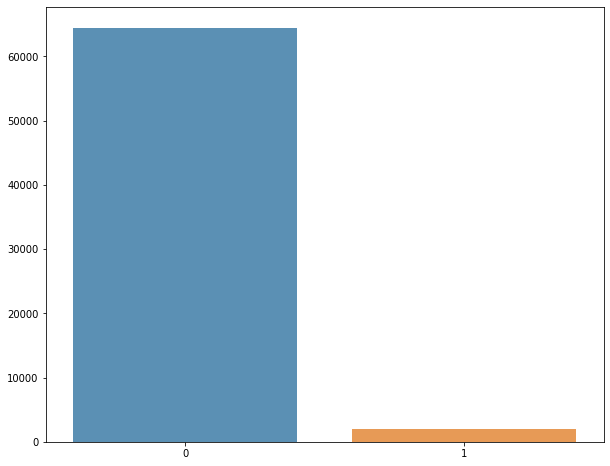

severe_toxic


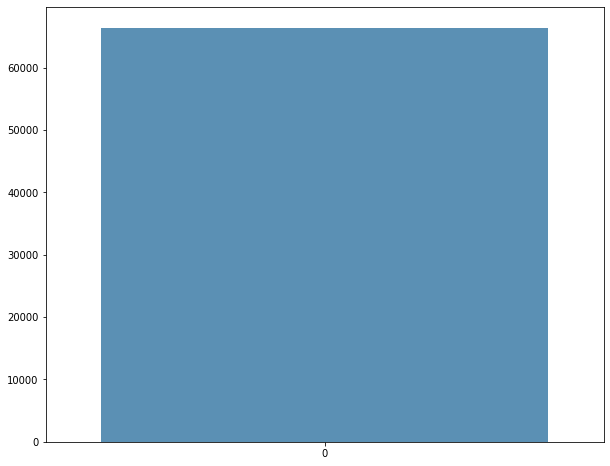

obscene


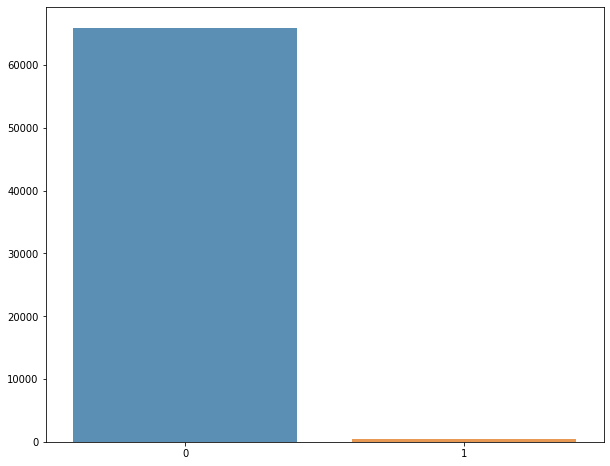

threat


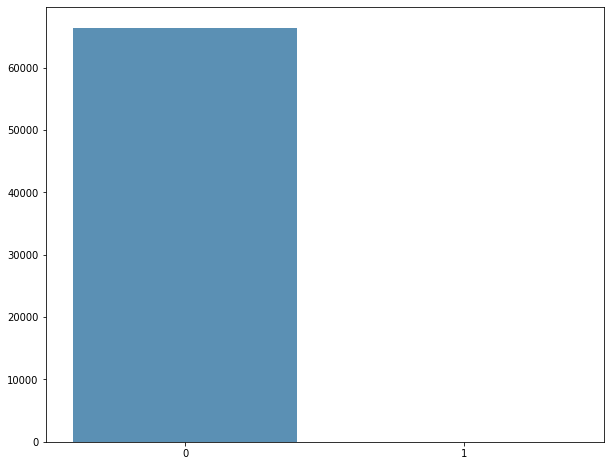

insult


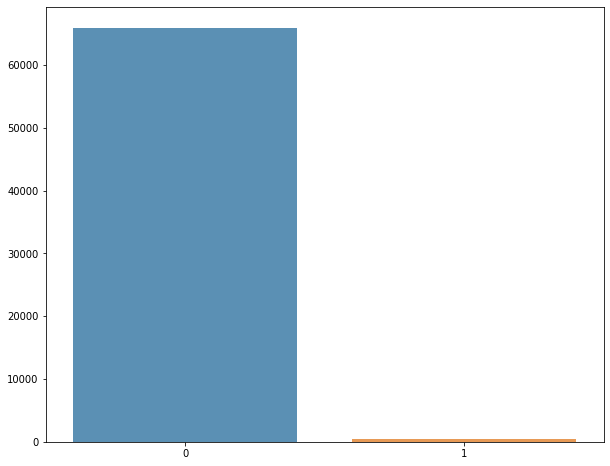

identity_hate


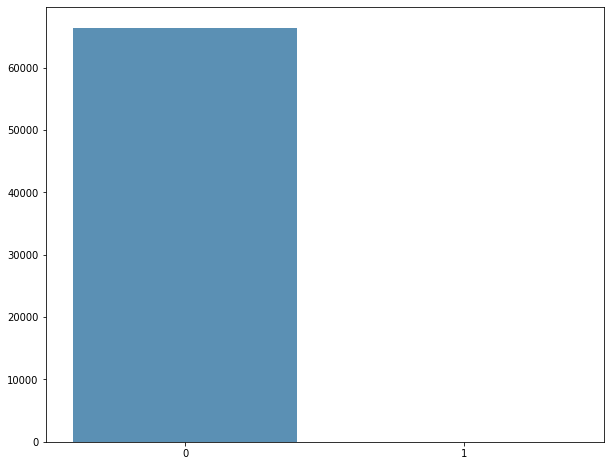

In [94]:
# plotting the user features 

for i in df.columns[11:17]:
  print(i)
  c=df[i].value_counts()
  sns.barplot(c.index, c.values, alpha=0.8)
  plt.show()

In [95]:
df.to_csv('test_dataset_predictions.csv', index=False)

In [96]:
df

,followers_count,following_count,listed_count,tweet_count,comment_text,created_at,retweet_count,reply_count,like_count,quote_count,CandidateA,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1771,3576,8,45328,ofpeopl agargmd mani peopl know stopthest prot...,2021-01-28 23:59:15+00:00,0,0,0,0,9.037520e+17,0,0,0,0,0,0
1,4,37,0,421,id say shock naiv ignor mani complain robinhoo...,2021-01-28 23:55:00+00:00,0,0,0,0,2.518376e+09,0,0,0,0,0,0
2,394,954,0,23278,dave larock fair censur fact particip number s...,2021-01-28 23:54:51+00:00,2,1,3,0,1.724066e+07,0,0,0,0,0,0
3,289,471,2,34442,govkristinoem yes joe notmypresid ilegitam sto...,2021-01-28 23:52:46+00:00,0,0,1,0,1.900454e+07,1,0,0,0,0,1
4,1727,2557,3,18984,senatorromney couldv work stopthest retain pre...,2021-01-28 23:52:41+00:00,0,0,1,0,1.250970e+18,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66441,7,29,1,113,sentedcruz last hope know must pleas back rep ...,2020-12-20 00:06:56+00:00,0,0,0,0,2.996814e+09,1,0,0,0,0,0
66442,106,440,1,6148,jaketapp judg laugh last laugh ps fu tapper st...,2020-12-20 00:04:58+00:00,0,0,0,0,1.712432e+08,0,0,0,0,0,0
66443,6129,1000,10,24696,true everi day fight novemb elect transpar amp...,2020-12-20 00:02:55+00:00,0,0,0,0,7.659790e+17,0,0,0,0,0,0
66444,4139,4997,0,97757,donotratifyfraud stopthest demand state repres...,2020-12-20 00:02:07+00:00,0,0,0,0,2.945379e+09,0,0,0,0,0,0


**Toxic Identity**

I'll seperate each category in a new dataframe. 

In [97]:
attributes = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [98]:
Insult_comment_df = df.loc[:,['CandidateA', 'comment_text', 'insult']]

In [99]:
IdentityHate_comment_df=df.loc[:,['CandidateA', 'comment_text', 'identity_hate']]

In [100]:
Toxic_comment_df = df.loc[:,['CandidateA', 'comment_text', 'toxic']]

In [101]:
SeverToxic_comment_df = df.loc[:,['CandidateA', 'comment_text', 'severe_toxic']]

In [102]:
Obscene_comment_df = df.loc[:,['CandidateA', 'comment_text', 'obscene']]

In [103]:
Threat_comment_df = df.loc[:,['CandidateA', 'comment_text', 'threat']]

In [104]:
Toxic_comment_df

,CandidateA,comment_text,toxic
0,9.037520e+17,ofpeopl agargmd mani peopl know stopthest prot...,0
1,2.518376e+09,id say shock naiv ignor mani complain robinhoo...,0
2,1.724066e+07,dave larock fair censur fact particip number s...,0
3,1.900454e+07,govkristinoem yes joe notmypresid ilegitam sto...,1
4,1.250970e+18,senatorromney couldv work stopthest retain pre...,0
...,...,...,...
66441,2.996814e+09,sentedcruz last hope know must pleas back rep ...,1
66442,1.712432e+08,jaketapp judg laugh last laugh ps fu tapper st...,0
66443,7.659790e+17,true everi day fight novemb elect transpar amp...,0
66444,2.945379e+09,donotratifyfraud stopthest demand state repres...,0


In [105]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [106]:
# create a function to get all positive values for each feature: 

def wordcloud(df, label):
    
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=2000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

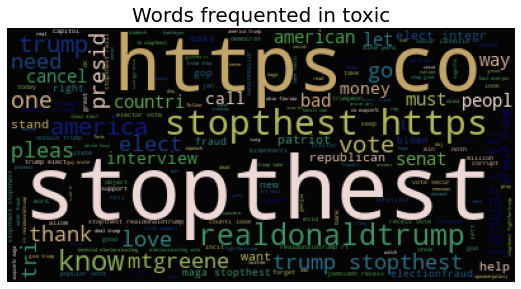

In [107]:
wordcloud(Toxic_comment_df,'toxic')

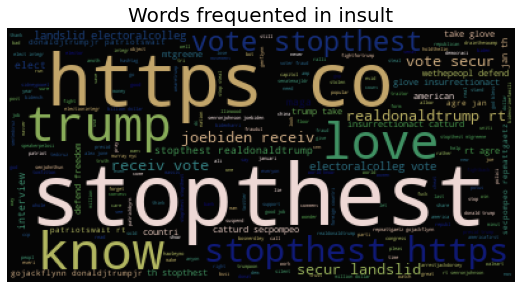

In [108]:
wordcloud(Insult_comment_df,'insult')

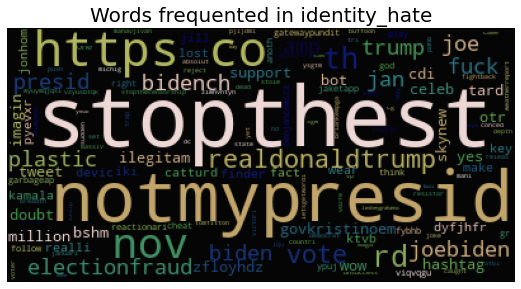

In [109]:
wordcloud(IdentityHate_comment_df,'identity_hate')

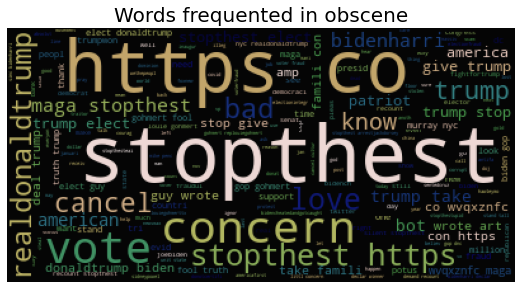

In [110]:
wordcloud(Obscene_comment_df,'obscene')

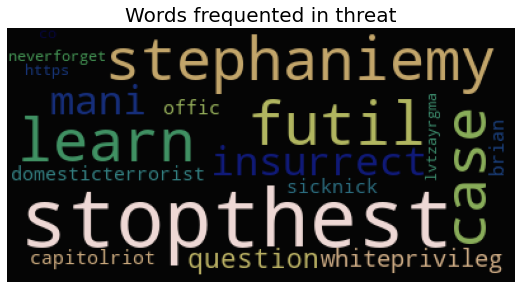

In [111]:
wordcloud(Threat_comment_df,'threat')

In [112]:
df = df.groupby(df.CandidateA).mean()
df['CandidateA'] = df.index
df

,followers_count,following_count,listed_count,tweet_count,retweet_count,reply_count,like_count,quote_count,toxic,severe_toxic,obscene,threat,insult,identity_hate,CandidateA
CandidateA,,,,,,,,,,,,,,,
4.999000e+03,10510.0,374.0,785.0,81986.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.999000e+03
6.463000e+03,2979.0,989.0,102.0,75075.000000,0.0,0.000000,1.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,6.463000e+03
1.059700e+04,49.0,106.0,0.0,19386.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.059700e+04
2.928300e+04,10275.0,11223.0,715.0,674104.666667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.928300e+04
3.092300e+04,42556.0,1153.0,2207.0,18982.000000,1.0,1.000000,13.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.092300e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.353730e+18,523.0,1279.0,13.0,11757.000000,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.353730e+18
1.354100e+18,0.0,61.0,0.0,177.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.354100e+18
1.354380e+18,3.0,24.0,0.0,2.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.354380e+18


**Correlation among the comment categories**

In [113]:
#Number of df texts labelled in different categories
df[attributes].sum()

obscene          182.896852
insult           160.123517
toxic            721.968111
severe_toxic       0.000000
identity_hate     11.419612
threat             1.333333
dtype: float64

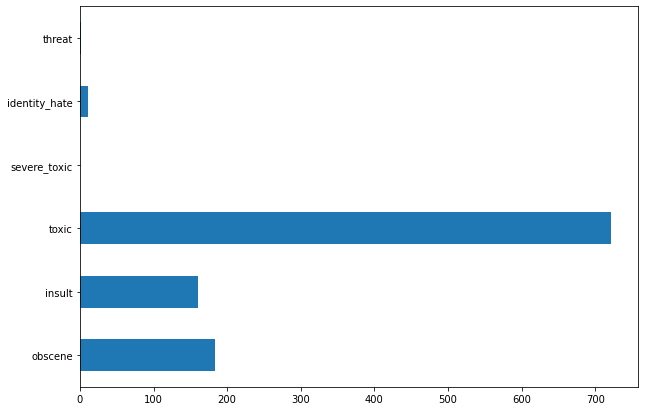

In [114]:
df[attributes].sum().plot(kind = 'barh', figsize=(10, 7));
# plt.title()

Heat map of correlations

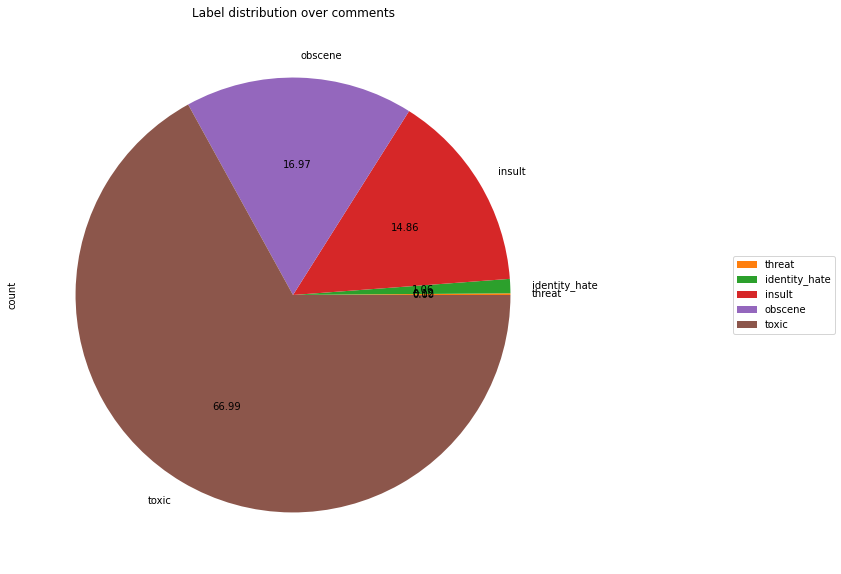

In [117]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_distribution = df[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))